# RSI Divergence

In [1]:
#Import basic libraries
%matplotlib inline


import os
import sys
import settings
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from django_pandas.io import read_frame
from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.dates as mpl_dates

from matplotlib.dates import date2num

#Prepare to load stock data as pandas dataframe from source. In this case, prepare django
import django
os.environ.setdefault('DJANGO_SETTINGS_MODULE', 'rest.settings')
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"
django.setup()

from stocks.models import Listing, Stock, Market

#Import TA-lib and backtesting library
import talib
from talib.abstract import *
from talib import MA_Type

from tvDatafeed_edge import TvDatafeed, Interval

username = 'blasphemous_aesthete'
password = 'anshulthakur@123'

tv = TvDatafeed(username, password, auto_login=True)

In [2]:
use_tv = True

interval = 5
#n_bars = int((6.25)*60/interval)+14
n_bars = 50
if use_tv:
    df = tv.get_hist(
                "NIFTY",
                "NSE",
                interval=eval(f"Interval.in_{interval}_minute"),
                n_bars=n_bars,
                extended_session=False,
            )
else:
    df = pd.read_csv('./NIFTY50.csv', index_col=0)
    for column in df.columns:
        if column != 'date':
           df[column] = pd.to_numeric(df[column])
    df.index = pd.to_datetime(df.index)
    df.index = df.index.tz_localize(None)

    df = df.sort_index()
    df = df.reindex(columns = ['open', 'high', 'low', 'close', 'volume'])
    df = df[~df.index.duplicated(keep='first')]

#Check if NA values are in data
#df.isna().sum()

In [ ]:
#df.tail(10)

In [3]:
import numpy as np
#import pandas_ta as ta
import talib as ta
#df.ta.indicators()
#help(ta.rsi)
df['RSI'] = ta.RSI(df.close, timeperiod=14)

def myRSI(price, n=20):
    delta = price['close'].diff()
    dUp, dDown = delta.copy(), delta.copy()
    dUp[dUp < 0] = 0
    dDown[dDown > 0] = 0

    RolUp = dUp.rolling(window=n).mean()
    RolDown = dDown.rolling(window=n).mean().abs()
    
    RS = RolUp / RolDown
    rsi= 100.0 - (100.0 / (1.0 + RS))
    return rsi

#df['RSI'] = myRSI(df)

df.dropna(inplace=True)
#df.reset_index(drop=True, inplace=True)
#df.head(20)

In [ ]:
#import sys
#!{sys.executable} -m pip install plotly --upgrade --no-cache-dir

In [ ]:
#df = df["2015-01-09 09:15:00":"2015-01-09 15:30:00"]
#df.head(20)

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime

fig = make_subplots(rows=2, cols=1)
fig.append_trace(go.Candlestick(x=df.index,
                open=df['open'],
                high=df['high'],
                low=df['low'],
                close=df['close']), row=1, col=1)
fig.append_trace(go.Scatter(
    x=df.index,
    y=df['RSI'],
), row=2, col=1)
fig.update_xaxes(
        rangeslider_visible=True,
        rangebreaks=[
            # NOTE: Below values are bound (not single values), ie. hide x to y
            dict(bounds=["sat", "mon"]),  # hide weekends, eg. hide sat to before mon
            dict(bounds=[15.5, 9.25], pattern="hour"),  # hide hours outside of 9.30am-4pm
            # dict(values=["2020-12-25", "2021-01-01"])  # hide holidays (Christmas and New Year's, etc)
        ]
    )
fig.update_layout(xaxis_rangeslider_visible=False)
fig.show()

In [ ]:
def pivotid(df1, l, n1, n2): #n1 n2 before and after candle l
    if l-n1 < 0 or l+n2 >= len(df1):
        return 0
    
    pividlow=1
    pividhigh=1
    for i in range(l-n1, l+n2+1):
        if(df1.low[l]>df1.low[i]):
            pividlow=0
        if(df1.high[l]<df1.high[i]):
            pividhigh=0
    if pividlow and pividhigh:
        return 3
    elif pividlow:
        return 1
    elif pividhigh:
        return 2
    else:
        return 0

def RSIpivotid(df1, l, n1, n2): #n1 n2 before and after candle l
    if l-n1 < 0 or l+n2 >= len(df1):
        return 0

    pividlow=1
    pividhigh=1
    for i in range(l-n1, l+n2+1):
        if(df1.RSI[l]>df1.RSI[i]):
            pividlow=0
        if(df1.RSI[l]<df1.RSI[i]):
            pividhigh=0
    if pividlow and pividhigh:
        return 3
    elif pividlow:
        return 1
    elif pividhigh:
        return 2
    else:
        return 0 
#pivotid(df,28145,5,5)

In [ ]:
def pointpos(x):
    if x['pivot']==1:
        return x['low']-1e-3
    elif x['pivot']==2:
        return x['high']+1e-3
    else:
        return np.nan

def RSIpointpos(x):
    if x['RSIpivot']==1:
        return x['RSI']-1
    elif x['RSIpivot']==2:
        return x['RSI']+1
    else:
        return np.nan

In [ ]:
df['pivot'] = df.apply(lambda x: pivotid(df, df.index.get_loc(x.name),2,1), axis=1)
df['RSIpivot'] = df.apply(lambda x: RSIpivotid(df, df.index.get_loc(x.name), 2, 1), axis=1)
df['pointpos'] = df.apply(lambda row: pointpos(row), axis=1)
df['RSIpointpos'] = df.apply(lambda row: RSIpointpos(row), axis=1)
#df[df.RSIpivot==1].count()

In [ ]:
dfpl = df
fig = make_subplots(rows=2, cols=1)
fig.append_trace(go.Candlestick(x=dfpl.index,
                open=dfpl['open'],
                high=dfpl['high'],
                low=dfpl['low'],
                close=dfpl['close']), row=1, col=1)

fig.add_scatter(x=dfpl.index, y=dfpl['pointpos'], mode="markers",
                marker=dict(size=4, color="MediumPurple"),
                name="pivot", row=1, col=1)

fig.append_trace(go.Scatter(x=dfpl.index, y=dfpl['RSI']), row=2, col=1)
fig.add_scatter(x=dfpl.index, y=dfpl['RSIpointpos'], mode="markers",
                marker=dict(size=4, color="MediumPurple"),
                name="pivot", row=2, col=1)

fig.update_xaxes(
        rangeslider_visible=True,
        rangebreaks=[
            # NOTE: Below values are bound (not single values), ie. hide x to y
            dict(bounds=["sat", "mon"]),  # hide weekends, eg. hide sat to before mon
            dict(bounds=[15.5, 9.25], pattern="hour"),  # hide hours outside of 9.30am-4pm
            # dict(values=["2020-12-25", "2021-01-01"])  # hide holidays (Christmas and New Year's, etc)
        ]
    )
fig.update_layout(xaxis_rangeslider_visible=False)
fig.show()

In [ ]:
#df

In [ ]:
import numpy as np
from matplotlib import pyplot
backcandles= 30

#candleid = 8800
candleid = 149

maxim = np.array([])
minim = np.array([])
xxmin = np.array([])
xxmax = np.array([])

maximRSI = np.array([])
minimRSI = np.array([])
xxminRSI = np.array([])
xxmaxRSI = np.array([])

for i in range(candleid-backcandles, candleid+1):
    if df.iloc[i].pivot == 1:
        minim = np.append(minim, df.iloc[i].low)
        xxmin = np.append(xxmin, df.index.get_loc(df.iloc[i].name)) #could be i instead df.iloc[i].name
    if df.iloc[i].pivot == 2:
        maxim = np.append(maxim, df.iloc[i].high)
        xxmax = np.append(xxmax, df.index.get_loc(df.iloc[i].name)) # df.iloc[i].name
    if df.iloc[i].RSIpivot == 1:
        minimRSI = np.append(minimRSI, df.iloc[i].RSI)
        xxminRSI = np.append(xxminRSI, df.index.get_loc(df.iloc[i].name))
    if df.iloc[i].RSIpivot == 2:
        maximRSI = np.append(maximRSI, df.iloc[i].RSI)
        xxmaxRSI = np.append(xxmaxRSI, df.index.get_loc(df.iloc[i].name))

print(minim)
print(xxmin)        
slmin, intercmin = np.polyfit(xxmin, minim,1)
slmax, intercmax = np.polyfit(xxmax, maxim,1)
slminRSI, intercminRSI = np.polyfit(xxminRSI, minimRSI,1)
slmaxRSI, intercmaxRSI = np.polyfit(xxmaxRSI, maximRSI,1)

#print(xxmin)
print(slmin, slmax, slminRSI, slmaxRSI)


dfpl = df[df.index[candleid-backcandles-5]:df.index[min(candleid+backcandles, len(df)-1)]]
#print(len(dfpl))
#print(dfpl.iloc[xxmin])
fig = make_subplots(rows=2, cols=1)
fig.append_trace(go.Candlestick(x=dfpl.index,
                open=dfpl['open'],
                high=dfpl['high'],
                low=dfpl['low'],
                close=dfpl['close']), row=1, col=1)
fig.add_scatter(x=dfpl.index, y=dfpl['pointpos'], mode="markers",
                marker=dict(size=4, color="MediumPurple"),
                name="pivot", row=1, col=1)
fig.add_trace(go.Scatter(x=df.iloc[xxmin].index, y=slmin*xxmin + intercmin, mode='lines', name='min slope'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.iloc[xxmax].index, y=slmax*xxmax + intercmax, mode='lines', name='max slope'), row=1, col=1)

fig.append_trace(go.Scatter(x=dfpl.index, y=dfpl['RSI']), row=2, col=1)
fig.add_scatter(x=dfpl.index, y=dfpl['RSIpointpos'], mode="markers",
                marker=dict(size=2, color="MediumPurple"),
                name="pivot", row=2, col=1)
fig.add_trace(go.Scatter(x=df.iloc[xxminRSI].index, y=slminRSI*xxminRSI + intercminRSI, mode='lines', name='min slope'), row=2, col=1)
fig.add_trace(go.Scatter(x=df.iloc[xxmaxRSI].index, y=slmaxRSI*xxmaxRSI + intercmaxRSI, mode='lines', name='max slope'), row=2, col=1)

fig.update_layout(xaxis_rangeslider_visible=False)
fig.show()

# Fitting pivots into slopes

In [ ]:
dfpl = df
def divsignal(candleid, nbackcandles):
    backcandles=nbackcandles 

    maxim = np.array([])
    minim = np.array([])
    xxmin = np.array([])
    xxmax = np.array([])

    maximRSI = np.array([])
    minimRSI = np.array([])
    xxminRSI = np.array([])
    xxmaxRSI = np.array([])

    for i in range(candleid-backcandles, candleid+1):
        if df.iloc[i].pivot == 1:
            minim = np.append(minim, df.iloc[i].low)
            xxmin = np.append(xxmin, df.index.get_loc(df.iloc[i].name)) #could be i instead df.iloc[i].name
        if df.iloc[i].pivot == 2:
            maxim = np.append(maxim, df.iloc[i].high)
            xxmax = np.append(xxmax, df.index.get_loc(df.iloc[i].name)) # df.iloc[i].name
        if df.iloc[i].RSIpivot == 1:
            minimRSI = np.append(minimRSI, df.iloc[i].RSI)
            xxminRSI = np.append(xxminRSI, df.index.get_loc(df.iloc[i].name))
        if df.iloc[i].RSIpivot == 2:
            maximRSI = np.append(maximRSI, df.iloc[i].RSI)
            xxmaxRSI = np.append(xxmaxRSI, df.index.get_loc(df.iloc[i].name))

    if maxim.size<2 or minim.size<2 or maximRSI.size<2 or minimRSI.size<2:
        return 0
    
    slmin, intercmin = np.polyfit(xxmin, minim,1)
    slmax, intercmax = np.polyfit(xxmax, maxim,1)
    slminRSI, intercminRSI = np.polyfit(xxminRSI, minimRSI,1)
    slmaxRSI, intercmaxRSI = np.polyfit(xxmaxRSI, maximRSI,1)
    
    
    if slmin > 1e-4 and slmax > 1e-4 and slmaxRSI <-0.1:
        return 1
    elif slmin < -1e-4 and slmax < -1e-4 and slminRSI > 0.1:
        return 2
    else:
        return 0

dfpl['divSignal'] = dfpl.apply(lambda row: divsignal(dfpl.index.get_loc(row.name),5), axis=1)
dfpl

In [ ]:
print(dfpl[dfpl.divSignal==2].count())
dfpl[dfpl.divSignal==2]

# pivot points levels instead of slopes

In [ ]:
dfpl = df
def divsignal2(candleid, nbackcandles):
    backcandles=nbackcandles 

    closp = np.array([])
    xxclos = np.array([])
    
    maxim = np.array([])
    minim = np.array([])
    xxmin = np.array([])
    xxmax = np.array([])

    maximRSI = np.array([])
    minimRSI = np.array([])
    xxminRSI = np.array([])
    xxmaxRSI = np.array([])

    for i in range(candleid-backcandles, candleid+1):
        closp = np.append(closp, df.iloc[i].close)
        xxclos = np.append(xxclos, df.index.get_loc(df.iloc[i].name))
        if df.iloc[i].pivot == 1:
            minim = np.append(minim, df.iloc[i].low)
            xxmin = np.append(xxmin, df.index.get_loc(df.iloc[i].name)) #could be i instead df.iloc[i].name
        if df.iloc[i].pivot == 2:
            maxim = np.append(maxim, df.iloc[i].high)
            xxmax = np.append(xxmax, df.index.get_loc(df.iloc[i].name)) # df.iloc[i].name
        if df.iloc[i].RSIpivot == 1:
            minimRSI = np.append(minimRSI, df.iloc[i].RSI)
            xxminRSI = np.append(xxminRSI, df.index.get_loc(df.iloc[i].name))
        if df.iloc[i].RSIpivot == 2:
            maximRSI = np.append(maximRSI, df.iloc[i].RSI)
            xxmaxRSI = np.append(xxmaxRSI, df.index.get_loc(df.iloc[i].name))

    slclos, interclos = np.polyfit(xxclos, closp,1)
    
    if slclos > 1e-4 and (maximRSI.size<2 or maxim.size<2):
        return 0
    if slclos < -1e-4 and (minimRSI.size<2 or minim.size<2):
        return 0
# signal decisions here !!!
    if slclos > 1e-4:
        if maximRSI[-1]<maximRSI[-2] and maxim[-1]>maxim[-2]:
            return 1
    elif slclos < -1e-4:
        if minimRSI[-1]>minimRSI[-2] and minim[-1]<minim[-2]:
            return 2
    else:
        return 0

dfpl['divSignal2'] = dfpl.apply(lambda row: divsignal2(df.index.get_loc(row.name),5), axis=1)
dfpl

In [ ]:
print(dfpl[dfpl.divSignal2==2].count())
dfpl[dfpl.divSignal2==1]

The trouble with this code is that it relies on a window size and sometimes, the window parameter may not cut it. We want an adaptive window. Further, it is relying on slopes which may mislead if distance between points is small (pivots too close)

Instead, we consider a more 'theoretical' strategy of first figuring out if the price and RSI are making HH-HL or LH-LL structures and then working with it.

In [4]:
#RSI Divergence strategy
#https://raposa.trade/blog/test-and-trade-rsi-divergence-in-python

from scipy.signal import argrelextrema
from collections import deque

def getHigherLows(data: np.array, order=5, K=2):
  '''
  Finds consecutive higher lows in price pattern.
  Must not be exceeded within the number of periods indicated by the width 
  parameter for the value to be confirmed.
  K determines how many consecutive lows need to be higher.
  '''
  # Get lows
  low_idx = argrelextrema(data, np.less, order=order)[0]
  lows = data[low_idx]
  # Ensure consecutive lows are higher than previous lows
  extrema = []
  ex_deque = deque(maxlen=K)
  for i, idx in enumerate(low_idx):
    if i == 0:
      ex_deque.append(idx)
      continue
    if lows[i] < lows[i-1]:
      ex_deque.clear()

    ex_deque.append(idx)
    if len(ex_deque) == K:
      extrema.append(ex_deque.copy())

  return extrema

def getLowerHighs(data: np.array, order=5, K=2):
  '''
  Finds consecutive lower highs in price pattern.
  Must not be exceeded within the number of periods indicated by the width 
  parameter for the value to be confirmed.
  K determines how many consecutive highs need to be lower.
  '''
  # Get highs
  high_idx = argrelextrema(data, np.greater, order=order)[0]
  highs = data[high_idx]
  # Ensure consecutive highs are lower than previous highs
  extrema = []
  ex_deque = deque(maxlen=K)
  for i, idx in enumerate(high_idx):
    if i == 0:
      ex_deque.append(idx)
      continue
    if highs[i] > highs[i-1]:
      ex_deque.clear()

    ex_deque.append(idx)
    if len(ex_deque) == K:
      extrema.append(ex_deque.copy())

  return extrema

def getHigherHighs(data: np.array, order=5, K=2):
  '''
  Finds consecutive higher highs in price pattern.
  Must not be exceeded within the number of periods indicated by the width 
  parameter for the value to be confirmed.
  K determines how many consecutive highs need to be higher.
  '''
  # Get highs
  high_idx = argrelextrema(data, np.greater, order=5)[0]
  highs = data[high_idx]
  # Ensure consecutive highs are higher than previous highs
  extrema = []
  ex_deque = deque(maxlen=K)
  for i, idx in enumerate(high_idx):
    if i == 0:
      ex_deque.append(idx)
      continue
    if highs[i] < highs[i-1]:
      ex_deque.clear()

    ex_deque.append(idx)
    if len(ex_deque) == K:
      extrema.append(ex_deque.copy())

  return extrema

def getLowerLows(data: np.array, order=5, K=2):
  '''
  Finds consecutive lower lows in price pattern.
  Must not be exceeded within the number of periods indicated by the width 
  parameter for the value to be confirmed.
  K determines how many consecutive lows need to be lower.
  '''
  # Get lows
  low_idx = argrelextrema(data, np.less, order=order)[0]
  lows = data[low_idx]
  # Ensure consecutive lows are lower than previous lows
  extrema = []
  ex_deque = deque(maxlen=K)
  for i, idx in enumerate(low_idx):
    if i == 0:
      ex_deque.append(idx)
      continue
    if lows[i] > lows[i-1]:
      ex_deque.clear()

    ex_deque.append(idx)
    if len(ex_deque) == K:
      extrema.append(ex_deque.copy())

  return extrema


IndexError: arrays used as indices must be of integer or boolean type

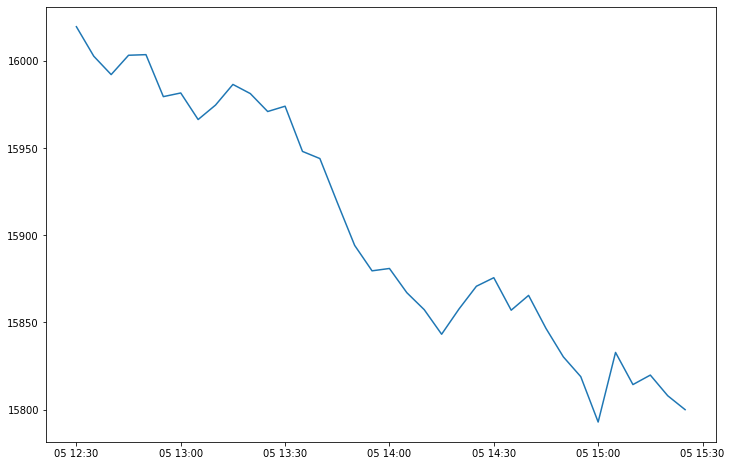

In [5]:
from matplotlib.lines import Line2D # For legend
price = df['close'].values
dates = df.index
# Get higher highs, lower lows, etc.
order = 1
hh = getHigherHighs(price, order)
#print(hh)
lh = getLowerHighs(price, order)
ll = getLowerLows(price, order)
hl = getHigherLows(price, order)
# Get confirmation indices
hh_idx = np.array([min(i[1] , len(df)-1) for i in hh])
#print(hh_idx)
lh_idx = np.array([min(i[1] , len(df)-1) for i in lh])
ll_idx = np.array([min(i[1] , len(df)-1) for i in ll])
hl_idx = np.array([min(i[1] , len(df)-1) for i in hl])
# Plot results
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.figure(figsize=(12, 8))
plt.plot(df['close'])
plt.scatter(dates[hh_idx], price[hh_idx-order], marker='^', c=colors[1])
plt.scatter(dates[lh_idx], price[lh_idx-order], marker='v', c=colors[2])
plt.scatter(dates[ll_idx], price[ll_idx-order], marker='v', c=colors[3])
plt.scatter(dates[hl_idx], price[hl_idx-order], marker='^', c=colors[4])
_ = [plt.plot(dates[i], price[i], c=colors[1]) for i in hh]
_ = [plt.plot(dates[i], price[i], c=colors[2]) for i in lh]
_ = [plt.plot(dates[i], price[i], c=colors[3]) for i in ll]
_ = [plt.plot(dates[i], price[i], c=colors[4]) for i in hl]
plt.xlabel('Date')
plt.ylabel('Price (Rs)')
plt.title(f'Potential Divergence Points for  Closing Price')
legend_elements = [
  Line2D([0], [0], color=colors[0], label='Close'),
  Line2D([0], [0], color=colors[1], label='Higher Highs'),
  Line2D([0], [0], color='w',  marker='^',
         markersize=10,
         markerfacecolor=colors[1],
         label='Higher Highs Confirmation'),
  Line2D([0], [0], color=colors[2], label='Lower Highs'),
  Line2D([0], [0], color='w',  marker='v',
         markersize=10,
         markerfacecolor=colors[2],
         label='Lower Highs Confirmation'),
  Line2D([0], [0], color=colors[3], label='Lower Lows'),
  Line2D([0], [0], color='w',  marker='v',
         markersize=10,
         markerfacecolor=colors[3],
         label='Lower Lows Confirmation'),
  Line2D([0], [0], color=colors[4], label='Higher Lows'),
  Line2D([0], [0], color='w',  marker='^',
         markersize=10,
         markerfacecolor=colors[4],
         label='Higher Lows Confirmation')
]
plt.legend(handles=legend_elements, bbox_to_anchor=(1, 0.65))
plt.show()

In [ ]:
rsi = df['RSI'].values
rsi_hh = getHigherHighs(rsi, order)
rsi_lh = getLowerHighs(rsi, order)
rsi_ll = getLowerLows(rsi, order)
rsi_hl = getHigherLows(rsi, order)

# Get confirmation indices
rsi_hh_idx = np.array([min(i[1] + order, len(df)-1) for i in rsi_hh])
rsi_lh_idx = np.array([min(i[1] + order, len(df)-1) for i in rsi_lh])
rsi_ll_idx = np.array([min(i[1] + order, len(df)-1) for i in rsi_ll])
rsi_hl_idx = np.array([min(i[1] + order, len(df)-1) for i in rsi_hl])

fig, ax = plt.subplots(2, figsize=(20, 12), sharex=True)
ax[0].plot(df['close'])
ax[0].scatter(dates[hh_idx], price[hh_idx-order], marker='^', c=colors[1])
ax[0].scatter(dates[lh_idx], price[lh_idx-order], marker='v', c=colors[2])
ax[0].scatter(dates[ll_idx], price[ll_idx-order], marker='v', c=colors[3])
ax[0].scatter(dates[hl_idx], price[hl_idx-order], marker='^', c=colors[4])
_ = [ax[0].plot(dates[i], price[i], c=colors[1]) for i in hh]
_ = [ax[0].plot(dates[i], price[i], c=colors[2]) for i in lh]
_ = [ax[0].plot(dates[i], price[i], c=colors[3]) for i in ll]
_ = [ax[0].plot(dates[i], price[i], c=colors[4]) for i in hl]
ax[0].set_ylabel('Price (Rs)')
ax[0].set_title(f'Price and Potential Divergence Points for Nifty')
ax[0].legend(handles=legend_elements)
ax[1].plot(df['RSI'])
ax[1].scatter(dates[rsi_hh_idx], rsi[rsi_hh_idx-order], marker='^', c=colors[1])
ax[1].scatter(dates[rsi_lh_idx], rsi[rsi_lh_idx-order], marker='v', c=colors[2])
ax[1].scatter(dates[rsi_ll_idx], rsi[rsi_ll_idx-order], marker='v', c=colors[3])
ax[1].scatter(dates[rsi_hl_idx], rsi[rsi_hl_idx-order], marker='^', c=colors[4])
_ = [ax[1].plot(dates[i], rsi[i], c=colors[1]) for i in rsi_hh]
_ = [ax[1].plot(dates[i], rsi[i], c=colors[2]) for i in rsi_lh]
_ = [ax[1].plot(dates[i], rsi[i], c=colors[3]) for i in rsi_ll]
_ = [ax[1].plot(dates[i], rsi[i], c=colors[4]) for i in rsi_hl]

ax[1].set_ylabel('RSI')
ax[1].set_title(f'RSI and Potential Divergence Points for Nifty')
ax[1].set_xlabel('Date')
plt.tight_layout()
plt.show() 

In [ ]:
#RSI Divergence strategy
def getHHIndex(data: np.array, order=5, K=2):
  extrema = getHigherHighs(data, order, K)
  idx = np.array([i[-1] + order for i in extrema])
  return idx[np.where(idx<len(data))]

def getLHIndex(data: np.array, order=5, K=2):
  extrema = getLowerHighs(data, order, K)
  idx = np.array([i[-1] + order for i in extrema])
  return idx[np.where(idx<len(data))]

def getLLIndex(data: np.array, order=5, K=2):
  extrema = getLowerLows(data, order, K)
  idx = np.array([i[-1] + order for i in extrema])
  return idx[np.where(idx<len(data))]

def getHLIndex(data: np.array, order=5, K=2):
  extrema = getHigherLows(data, order, K)
  idx = np.array([i[-1] + order for i in extrema])
  return idx[np.where(idx<len(data))]

def getPeaks(data, key='close', order=5, K=2):
  vals = data[key].values
  hh_idx = getHHIndex(vals, order, K)
  lh_idx = getLHIndex(vals, order, K)
  ll_idx = getLLIndex(vals, order, K)
  hl_idx = getHLIndex(vals, order, K)

  data[f'{key}_highs'] = np.nan
  data[f'{key}_highs'][hh_idx] = 1
  data[f'{key}_highs'][lh_idx] = -1
  data[f'{key}_highs'] = data[f'{key}_highs'].ffill().fillna(0)
  data[f'{key}_lows'] = np.nan
  data[f'{key}_lows'][ll_idx] = 1
  data[f'{key}_lows'][hl_idx] = -1
  data[f'{key}_lows'] = data[f'{key}_highs'].ffill().fillna(0)
  return data

def getPeaks(data, key='close', order=5, K=2):
    
    vals = data[key].values
    hh_idx = getHHIndex(vals, order, K)
    lh_idx = getLHIndex(vals, order, K)
    
    a = np.empty(vals.shape)
    a[:] = np.nan
    a[hh_idx] = 1
    a[lh_idx] = -1
    #a = a.ffill().fillna(0)
    a[np.isnan(a)] = 0
    return a

def getValleys(data, key='close', order=5, K=2):
    vals = data[key].values
    ll_idx = getLLIndex(vals, order, K)
    hl_idx = getHLIndex(vals, order, K)
    
    a = np.empty(vals.shape)
    a[:] = np.nan
    a[ll_idx] = 1
    a[hl_idx] = -1
    #a = data[f'{key}_highs'].ffill().fillna(0)
    a[np.isnan(a)] = 0
    return a

close_highs = getPeaks(df, key='close', order=order)
close_lows = getValleys(df, key='close', order=order)

rsi_highs = getPeaks(df, key='RSI', order=order)
rsi_lows = getValleys(df, key='RSI', order=order)

print(df.index[np.where(close_highs==1)])
print(df.index[np.where(close_highs==-1)])
print(df.index[np.where(close_lows==1)])
print(df.index[np.where(close_lows==-1)])

print(rsi_highs)
print(rsi_lows)

In [ ]:
prev_low = False
def get_divergence(df, index):
    #print(index)
    global prev_low
    if rsi_lows[index] == 1: #Continuation of lower low
        prev_low = True
    elif rsi_highs[index] == -1: #Continuation of lower high
        prev_low = False
        
    if close_lows[index] == -1 and (rsi_lows[index] == 1 or prev_low==True): #Price makes lower low, indicator makes higher low (Positive divergence)
        return 1
    elif close_highs[index] == 1 and (rsi_highs[index] == -1 or prev_low==False): #Price making higher high, RSI making lower high (Negative divergence)
        return -1
df['divergence'] = df.apply(lambda x: get_divergence(df, df.index.get_loc(x.name)), axis=1)

In [ ]:
pos = df[df['divergence']==1]
neg = df[df['divergence']==-1]


print('Positive Divergences')
print(pos.head())
print(pos.count())

print('Negative Divergences')
print(neg.head())
print(neg.count())

In [ ]:
df.head()